<a href="https://colab.research.google.com/github/abdullah91998/Pi-Pupil-Detection/blob/main/Copy_of_Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [3]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-d3_8ucnv
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-d3_8ucnv
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

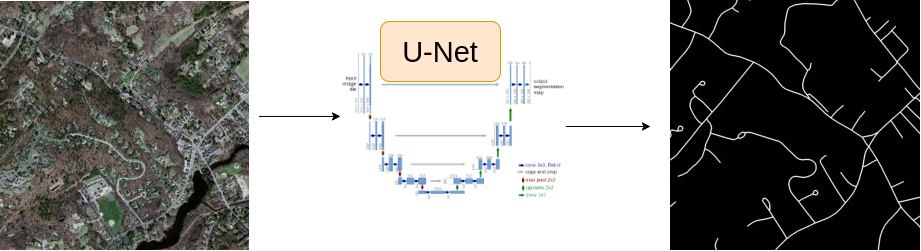

# Download Subset Dataset

In [4]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [5]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [6]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [7]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [9]:
idx = 20

row = df.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #CV2 ALWAYS TAKE IMAGE IN BGR format

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255 # we want pixel not in 255 but in 0to1

print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

Image shape: (1500, 1500, 3)
Mask shape: (1500, 1500)


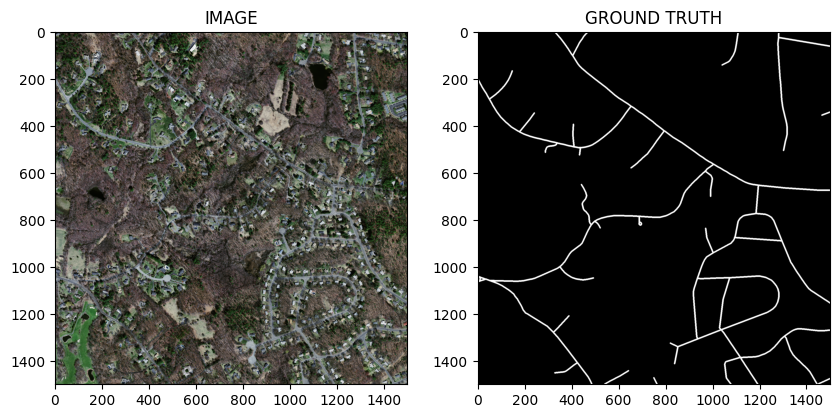

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [12]:
len(train_df)

159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [13]:
import albumentations as A

In [14]:
from albumentations.augmentations.geometric.transforms import VerticalFlip
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5), # here is image is rotaed it lable(mass) should also be changed insegmentation task
        VerticalFlip(p=0.5)
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ])

# Task 4 : Create Custom Dataset

In [15]:
from torch.utils.data import Dataset

In [16]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):


        row = df.iloc[idx]
        image_path = DATA_DIR + row.images
        mask_path = DATA_DIR + row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #CV2 ALWAYS TAKE IMAGE IN BGR format(h,w,c)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = -1) #(h,w,c)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask) # created dictionary and used augmentation on both image and label(mask)
            image = data['image']
            mask = data['mask']

        image =np.transpose(image, (2,0,1)).astype(np.float32) #(c,h,w)
        mask =np.transpose(mask, (2,0,1)).astype(np.float32) #(c,h,w)

        image = torch.Tensor(image)/255.0
        mask = torch.round(torch.Tensor(mask)/255.0)



        return image, mask

In [17]:
trainset = SegmentationDataset(train_df,get_train_augs()) #parenthesis since it is a function
validset = SegmentationDataset(valid_df,get_valid_augs())

In [18]:
print(f'sIZE of trainset : {len(trainset)}') #USING GETITEM
print(f'sIZE of trainset : {len(validset)}')

sIZE of trainset : 159
sIZE of trainset : 40


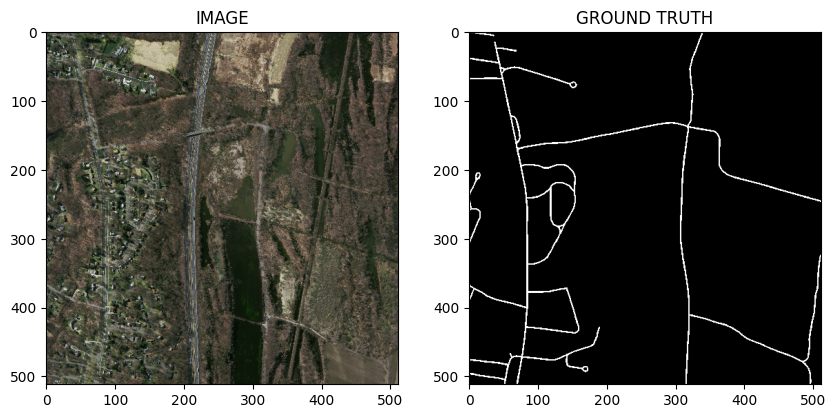

In [19]:
idx = 15

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [20]:
from torch.utils.data import DataLoader

In [21]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [22]:
print(f'total no of trainloader ; {len(trainloader)}')
print(f'total no of validloader ; {len(validloader)}')

total no of trainloader ; 20
total no of validloader ; 5


In [23]:
for images, masks in trainloader:
    print(f'one batch image shape : {images.shape}')
    print(f'one batch mask shape : {masks.shape}')
    break;

one batch image shape : torch.Size([8, 3, 512, 512])
one batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [24]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [25]:
from pandas.core.dtypes.common import classes
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.backbone = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )

    def forward(self, images, masks = None):
        logits = self.backbone(images)

        if masks !=None:
            return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

        return logits



In [26]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [27]:
def train_fn(dataloader, model, optimizer):

    model.train()

    total_loss = 0.0

    for images, masks in tqdm(dataloader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss =model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


In [28]:
def eval_fn(dataloader, model):

    model.eval()

    total_loss = 0.0
    with torch.no_grad():

        for images, masks in tqdm(dataloader):

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)


            logits, loss =model(images, masks)


            total_loss += loss.item()
        return total_loss / len(dataloader)


# Task 8 : Train Model

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr =LR)

In [30]:
best_loss = np.Inf
for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_loss:
        torch.save(model.state_dict(), "best-model.pt")
        print("saved-moedl")
        best_loss = valid_loss

    print(f"epoch :{i+1} Trainloss: {train_loss} validloss:{valid_loss}")


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


saved-moedl
epoch :1 Trainloss: 1.1168557554483414 validloss:1.0422045707702636


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


saved-moedl
epoch :2 Trainloss: 0.8303487569093704 validloss:0.7864951491355896


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


saved-moedl
epoch :3 Trainloss: 0.7303584724664688 validloss:0.7209324240684509


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


epoch :4 Trainloss: 0.7152170747518539 validloss:0.7813354730606079


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


saved-moedl
epoch :5 Trainloss: 0.6742572635412216 validloss:0.680849814414978


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


epoch :6 Trainloss: 0.6597492009401321 validloss:0.740279221534729


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


saved-moedl
epoch :7 Trainloss: 0.6534856855869293 validloss:0.663144314289093


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


saved-moedl
epoch :8 Trainloss: 0.6461142182350159 validloss:0.6185557246208191


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


epoch :9 Trainloss: 0.6296677649021148 validloss:0.6482180953025818


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


epoch :10 Trainloss: 0.6397620946168899 validloss:0.6388947129249573


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


saved-moedl
epoch :11 Trainloss: 0.6312790304422379 validloss:0.6016586422920227


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


epoch :12 Trainloss: 0.6232521176338196 validloss:0.7057901501655579


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


saved-moedl
epoch :13 Trainloss: 0.6178973525762558 validloss:0.5879921674728393


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


epoch :14 Trainloss: 0.6197131261229515 validloss:0.5961688816547394


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


epoch :15 Trainloss: 0.6079692050814629 validloss:0.6069775283336639


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


epoch :16 Trainloss: 0.6106407523155213 validloss:0.596325421333313


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


saved-moedl
epoch :17 Trainloss: 0.6104556202888489 validloss:0.5698086738586425


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


epoch :18 Trainloss: 0.6071602329611778 validloss:0.6060693979263305


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


epoch :19 Trainloss: 0.5959147274494171 validloss:0.6255312561988831


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


epoch :20 Trainloss: 0.593398493528366 validloss:0.5704569518566132


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


epoch :21 Trainloss: 0.5793819099664688 validloss:0.600131344795227


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


saved-moedl
epoch :22 Trainloss: 0.583008523285389 validloss:0.5477428793907165


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


epoch :23 Trainloss: 0.5911441400647164 validloss:0.5564329743385314


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


epoch :24 Trainloss: 0.5796551436185837 validloss:0.5816752016544342


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

epoch :25 Trainloss: 0.578858794271946 validloss:0.5958417654037476


# Task 9 : Inference

In [32]:
idx = 17
model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c,h,w to (b,c,h,w))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1

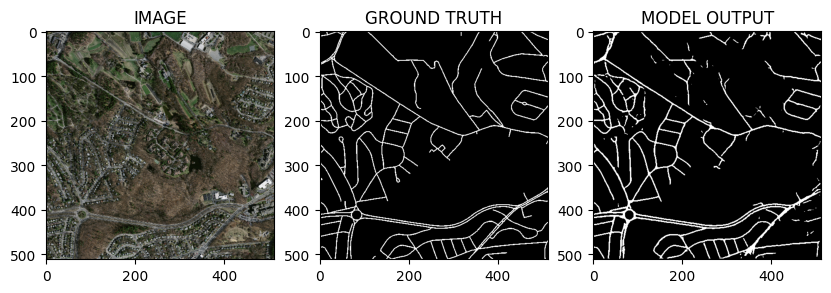

In [33]:
helper.show_image(image, mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

